In [3]:
from sklearn.datasets import load_files

train_files = load_files("aclImdb/train", shuffle=True, encoding='UTF-8')
test_files = load_files("aclImdb/test", shuffle=True, encoding='UTF-8')

In [4]:
print(train_files.data[:5])
print(train_files.target[:5])
print(train_files.filenames[:5])
print(train_files.target_names[:5])

["Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.", 'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many cliché

In [5]:
print("Number of training files :", len(train_files.target))
print("Number of testing files :", len(test_files.target))


Number of training files : 25000
Number of testing files : 25000


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100   #cut the review after 100 words
#training_samples = 200  # working only on 200 sample
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_files.data)
sequences = tokenizer.texts_to_sequences(train_files.data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))




Using TensorFlow backend.
/home/hwary/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hwary/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hwary/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hwary/anaconda3/lib/python3.7/site-packages/tensorflo

Found 88582 unique tokens.


In [7]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = train_files.target


In [8]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of labels tensor: (25000,)


In [9]:
x_train = data[ : validation_samples]
y_train = labels[ : validation_samples]

x_val = data[validation_samples : ]
y_val = labels[validation_samples : ]

print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

10000
10000
15000
15000


In [10]:
GloVe_dir = 'glove.6B/glove.6B.100d.txt'
embedding_index = {}
f = open(GloVe_dir)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs


f.close
    

<function TextIOWrapper.close()>

In [11]:
print('found %s word vectors.' % len(embedding_index))

found 400000 word vectors.


In [12]:
#build the embedding matrix
# Get all the 10000 word vectors ndex from the Glove which has 400000 vector

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))  # 10 000 * 100 matrix

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense, Dropout

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen )) # 10000, 100, 100
model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           42240     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,451,969

In [14]:
# set the weight of the GloVe and make it untrainable

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
# compile the model
from keras import optimizers

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5) ,
    loss='binary_crossentropy',
    metrics=['acc'],)

# history not hostory, but it is fine it is just a var
hostory = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10000 samples, validate on 15000 samples
Epoch 1/20
10000/10000 [==============================] - 33s 3ms/step - loss: 0.7025 - acc: 0.5057 - val_loss: 0.6895 - val_acc: 0.5408
Epoch 2/20
10000/10000 [==============================] - 29s 3ms/step - loss: 0.6936 - acc: 0.5163 - val_loss: 0.6879 - val_acc: 0.5475
Epoch 3/20
10000/10000 [==============================] - 30s 3ms/step - loss: 0.6902 - acc: 0.5357 - val_loss: 0.6838 - val_acc: 0.5815
Epoch 4/20
10000/10000 [==============================] - 29s 3ms/step - loss: 0.6881 - acc: 0.5407 - val_loss: 0.6812 - val_acc: 0.5977
Epoch 5/20
10000/10000 [==============================] - 29s 3ms/step - loss: 0.6875 - acc: 0.5396 - val_loss: 0.6796 - val_acc: 0.6054
Epoch 6/20
10000/10000 [==============================] - 29s 3ms/step - loss: 0.6837 - acc: 0.5562 - val_loss: 0.6792 - val_acc: 0.5557
Epoch 7/20
10000/10000 [=========

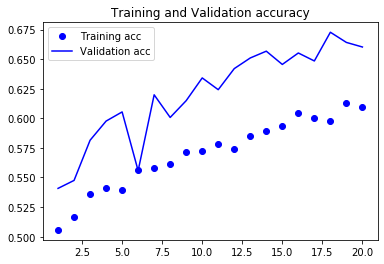

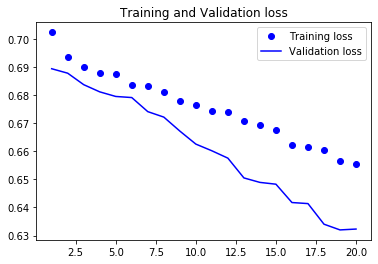

In [20]:
import matplotlib.pyplot as plt

acc = hostory.history['acc']
val_acc = hostory.history['val_acc']
loss = hostory.history['loss']
val_loss = hostory.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [17]:
test_tokenizer = Tokenizer(num_words=max_words)
test_tokenizer.fit_on_texts(test_files.data)
test_sequences = test_tokenizer.texts_to_sequences(test_files.data)

x_test = pad_sequences(test_sequences, maxlen=maxlen)
y_test = test_files.target

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test, steps=20)

20/20 [==============================] - 492s 25s/step


In [19]:
print("test acc = ", test_acc)
print("test loss = ", test_loss)

test acc =  0.5357599854469299
test loss =  0.6891054511070251


# Next part will be working on how to get better results